## Changing training paradigm to create a velocity corrector

In [ ]:
# How they are created from high-fidelity data:
    # before:
        # X_train: mean pooling, then Nearest Neighbours interpolation
        # Y_train: n/a
    # now: 
        # X_train: mean pooling
        # Y_train: sampling (reduces size to network input size)

In [20]:
#imports
import jax
import jax.numpy as jnp
from jax import value_and_grad

from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base.finite_differences import divergence
import jax_cfd.base as cfd
import jax_cfd.base.grids as grids

import haiku as hk
import gin
import numpy as np
import xarray
import random

import pickle
from diego_model_utils import SaveObject, forward_pass_module

import matplotlib.pyplot as plt
import seaborn

In [77]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [78]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = jnp.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
    ])
    high_def.append(this_time)

In [79]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


In [80]:
high_def = high_def[0::50]

In [81]:
np.shape(high_def)

(173, 256, 64, 2)

In [82]:
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))



Training dataset shape: 
	(173, 256, 64, 2)


In [83]:
originalMax = np.max(high_def)
originalMin = (np.min(high_def))
print(originalMin,originalMax)

-0.7672701 1.0142457


In [84]:
def increaseSize(input, factor):
    w,h = np.shape(input)
    output = np.zeros((w*factor,h*factor))
    
    for width in range(w*factor):
        for height in range(h*factor):
            output[width][height] = input[width//factor][height//factor]
    return output


def mean_pooling(input,factor):
    """performs a mean pooling operation"""
    
    w,h = np.shape(input)
    if w%factor != 0 or h%factor != 0:
        raise(AssertionError("Non-compatible input shape and downsample factor"))
    
    output = np.zeros((int(w/factor),int(h/factor)))
    
    for width in range(w):
        for height in range(h):
            output[width//factor][height//factor] += input[width][height]
    output /= factor**len(np.shape(output))
    return output

def downsampleHighDefVels(high_def,factor):
    low_def = []
    for vels in high_def:
        both_vels = []
        for vel in vels:
            vel = decreaseSize(vel,factor)

            vel = increaseSize(vel,factor)
            both_vels.append(vel)
        low_def.append(both_vels)
    return low_def

def sampling(input,factor):
    """performs sampling operation"""
    
    w,h = np.shape(input)
    if w%factor != 0 or h%factor != 0:
        raise(AssertionError("Non-compatible input shape and downsample factor"))
    
    output = np.zeros((int(w/factor),int(h/factor)))
    #print(np.shape(output))
    
    for width in range(0,w,factor):
        for height in range(0,h,factor):
            output[width//factor][height//factor] = input[width][height]
            
    return output
    

def creatingDataset(highDef,method,factor):
    """
    Performs ´method´ on contents of high_def
    
    e.g. method = mean_pooling
    This function performs a mean pooling operation on each frame within high_def
    
    """
    
    low_def = []
    for vels in highDef:
        
        u = method(np.array(vels[:,:,0]),factor) #output is a np.array
        
        
        v = method(np.array(vels[:,:,1]),factor) #output is a np.array
        
        
        low_def.append(jnp.dstack([
            u,
            v
        ]))
    return low_def



In [88]:
factor = 4
np.shape(creatingDataset(high_def,sampling,factor))

(173, 64, 16, 2)

In [90]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4



%time X_dataset = creatingDataset(high_def,mean_pooling,factor)
%time Y_dataset = creatingDataset(high_def,sampling,factor)

X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]

CPU times: user 4.04 s, sys: 8.69 ms, total: 4.05 s
Wall time: 4.07 s
CPU times: user 368 ms, sys: 1.04 ms, total: 369 ms
Wall time: 371 ms


In [91]:
def printAllShapes(*things):
    for thing in things:
        print(np.shape(thing))

printAllShapes(X_train,Y_train, X_test,Y_test)

(138, 64, 16, 2)
(138, 64, 16, 2)
(35, 64, 16, 2)
(35, 64, 16, 2)


In [92]:
np.shape(X_train[0])

(64, 16, 2)

In [93]:
def getUorV(data, u=0,xlen=256,ylen=64):
    out = []
    for point in data:
        out.append(
            jnp.dstack([
                point[:,:,u].reshape(xlen,ylen),
                point[:,:,u].reshape(xlen,ylen)
            ])
        )
    return out

In [94]:
np.shape(X_train)

(138, 64, 16, 2)

In [95]:
#extract u from u and v
# diego = getUorV(X_train)

# X_train = getUorV(X_train)
# Y_train = getUorV(Y_train)

# X_test = getUorV(X_test)
# Y_test = getUorV(Y_test)

In [96]:
#reference:
# https://goodboychan.github.io/python/deep_learning/vision/tensorflow-keras/2020/10/13/01-Super-Resolution-CNN.html#Build-SR-CNN-Model

def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= float(target_data.shape[0] * target_data.shape[1])
    return err

In [97]:
def my_mse(pred,actual):
    err = (jnp.array(pred)-jnp.array(actual))**2
    return err.mean()


# print(jnp.array(mse(truth,pred)))
# print(jnp.power(jnp.array(truth) - jnp.array(pred), 2).mean())
# print(my_mse(pred,truth))

In [98]:
num_output_channels = 2
# spatial_size = 17
ndim = 2
input_channels = 2

rng_key = jax.random.PRNGKey(42)
tower_module = towers.forward_tower_factory #add scaling here

forward_pass = forward_pass_module(num_output_channels = num_output_channels, 
                                    ndim = ndim,
                                    tower_module = tower_module)
                                

forward_pass = hk.without_apply_rng(hk.transform(forward_pass))

In [99]:
# Reference:
# https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-guide-to-create-multi-layer-perceptrons-using-jax

In [100]:
def computePredAndTruth(params,input_data,actual):
    preds = []
    truth = []
    for i in range(len(input_data)):
        preds.append(forward_pass.apply(params, input_data[i]))
        truth.append(actual[i])
    return preds,truth






def UpdateWeights(weights,gradients):
    return weights - learning_rate * gradients

In [101]:
#this one works 
def MeanSquaredErrorLoss(params, input_data, actual):
    preds,truth = computePredAndTruth(params,input_data,actual)
    return jnp.power(jnp.array(truth) - jnp.array(preds), 2).mean()

def MeanSquaredErrorLossWithDivergence(params, input_data, actual):
    preds,truth = computePredAndTruth(params,input_data,actual)
    mse = jnp.power(jnp.array(truth) - jnp.array(preds), 2).mean()
    div = divergence(v0)
    h = 1
    return mse + h * div


def absErrorLoss(params,input_data,actual):
    preds,truth = computePredAndTruth(params,input_data,actual)
    return ((jnp.array(truth) - jnp.array(preds))).mean()

def train_step(params, X_train, Y_train,X_val,Y_val):
    loss, param_grads = value_and_grad(MeanSquaredErrorLoss)(params, X_train, Y_train)
    val_loss = MeanSquaredErrorLoss(params, X_val,Y_val)
    return jax.tree_map(UpdateWeights, params, param_grads), loss, val_loss

In [135]:
learning_rate = jnp.array(0.005)


# this block creates a learning rate that changes after a set number of epochs
def staggeredLearningRate(*args):
    """
    accepts tuples with the following info:
    (number of epochs, learning rate)
    
    example usage: 
    learning_rates = staggeredLearningRate((50,0.005),(50,0.001))
    """
    learning_rates = []
    for arg in args:
        for i in range(arg[0]):
            learning_rates.append(arg[1])
    return learning_rates

learning_rates = staggeredLearningRate((1000,0.001))

In [103]:
truth = 11
approx = 10

def percentageError(approx, truth):
    return (approx-truth)/truth

def absPercentageError(approx,truth):
    return abs(percentageError(approx,truth))

print(percentageError(approx = 35,
                truth = 36))

print(absPercentageError(approx = 10,
                truth = 11))


-0.027777777777777776
0.09090909090909091


In [133]:
def train(X_train,Y_train,X_test,Y_test,rng_key,input_channels,epochs,params=None):
    """
    Input parameter 'params' allows us to keep training a network that has already undergone some 
    training, without having to retrain from scratch
    """
    
    shapes = np.shape(X_train)
    if input_channels != shapes[3]:
        raise(AssertionError("Non-compatible input shape and input channels"))

    sample_x = jax.random.uniform(rng_key, (shapes[1],shapes[2],input_channels))

    batch_size = 1
    if params == None:
        params = forward_pass.init(rng_key, sample_x)

    
    print("Shapes of all datasets")
    printAllShapes(X_train,Y_train,X_test,Y_test)
    print("\n")
    
    tol = 1e-5
    losses = []
    val_losses = []
    for i in range(1, epochs+1):

        learning_rate = learning_rates[i-1]

        params,loss,val_loss = train_step(params,X_train,Y_train,X_test,Y_test) #TODO: using test as validation, change this!

        
        if i%100 == 0: #every n epochs
            print("Epoch {:.0f}/{:.0f}".format(i,epochs))
            print("\tmse : {:.6f}\t".format(loss), end='')
            print("\tval mse : {:.6f}".format(val_loss), end='')
            print("\n")
        losses.append(loss)
        val_losses.append(val_loss)

        if i != 1:
            if abs(losses[-2]-losses[-1])<tol:
                print("\nConvergence reached at epoch {:.0f}".format(i))
                print("\tmse : {:.6f}\t".format(loss), end='')
                print("\tval mse : {:.6f}".format(val_loss), end='')
                print("\n")
                break

    if i == epochs:
        print("\nFinished training at max epochs\n")
    
    return losses, val_losses, params

In [ ]:
%time losses,val_losses,params = train(X_train,Y_train,X_test,Y_test,rng_key,input_channels,1000,params=loaded.params)

Shapes of all datasets
(138, 64, 16, 2)
(138, 64, 16, 2)
(35, 64, 16, 2)
(35, 64, 16, 2)




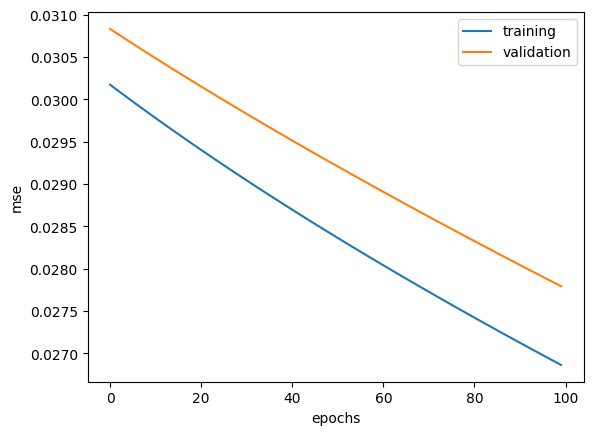

In [128]:
step = 1

plt.plot(losses[::step], label="training")
plt.plot(val_losses[::step],label="validation")
plt.ylabel("mse")
plt.xlabel("epochs")
# plt.yscale("log")
plt.legend()

## Saving model

In [129]:
toSave = SaveObject()
toSave.save_params(params)
toSave.save_forward_pass_params(num_output_channels,ndim,tower_module)

In [130]:
save_path = "./../models/velocity_correctors/second_new_paradigm.pickle"

In [131]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

## Loading model

In [132]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    loaded.make_forward_pass()
    loaded.preprocess()

## Predicting with loaded model

In [120]:
num =  11 #int(np.random.rand()*np.shape(X_test)[0]//1)
vel = 0      # 0 is u, 1 is v

pred = loaded.forward_pass.apply(loaded.params,X_test[num])

In [121]:
def vorticity(u,v):
    #dvdx - dudy
    return np.gradient(v,axis = 0) -np.gradient(u,axis = 1)

In [122]:
np.shape(pred)

(64, 16, 2)

In [125]:
pred = loaded.forward_pass.apply(loaded.params,X_test[num])
np.shape(pred)

vel = 1 #0 = u, 1 = v


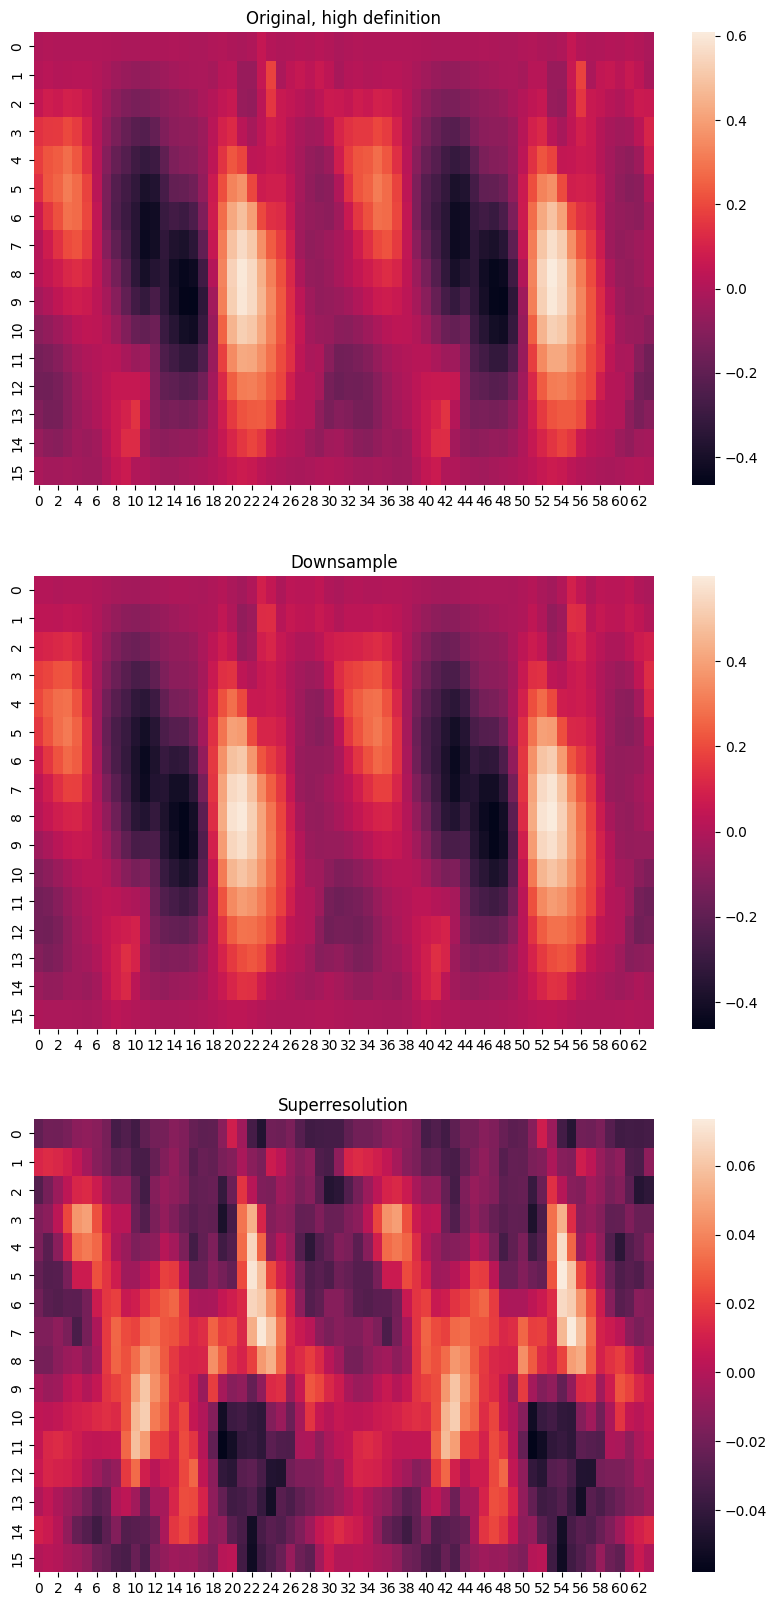

In [126]:
fig, axs = plt.subplots(3,1, facecolor='w', edgecolor='k',figsize=(10,20))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(Y_test[num][:,:,vel].T,ax = axs[0])
axs[0].title.set_text("Original, high definition")
im = seaborn.heatmap(X_test[num][:,:,vel].T,ax = axs[1])
axs[1].title.set_text("Downsample")
im = seaborn.heatmap(pred[:,:,vel].T,ax = axs[2])
axs[2].title.set_text("Superresolution")